In [11]:
# Dependencies
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import csv and quick clean dataframe for modeling. Leave secondary comments for alternative column models
mv_df = pd.read_csv(os.path.join("..", "Resources", "movie_metadata_adjusted_revenue_threegenres_reviews.csv"))
mv_df['popularity'] = mv_df['popularity'].astype(int)
mv_df['revenue'] = mv_df['revenue'].str.replace(',','').astype(str)
mv_df['top_critic_review_count'] = mv_df['top_critic_review_count'].astype(int)
mv_df['review_count'] = mv_df['review_count'].astype(int)
mv_df_final = mv_df.drop(columns={'title', 'release_date', 'runtime', 'first_genre',\
'second_genre', 'third_genre', 'Unnamed: 0'}, axis=1)

mv_df_final

budget  popularity        revenue  vote_average  vote_count  \
0       6000000          41  1499126346.72           8.5        6024   
1      25000000          51    48899552.11           8.5        8358   
2      63000000          63   154791744.55           8.3        9678   
3      22000000          41   568672494.68           8.3        4436   
4       3000000          35   517964907.39           8.3        3001   
...         ...         ...            ...           ...         ...   
1094   25000000          24    86673943.59           4.8        1075   
1095  150000000           9   373412184.37           4.7        1180   
1096   57000000           9   169652635.28           4.7        1163   
1097  125000000          17   379498823.02           4.2        1447   
1098    4000000          10    56562409.80           4.1        1034   

      top_critic_review_count  review_count  star_power  
0                          24            82           1  
1                          18            63           1  
2                          36           153           1  
3                          22            84           1  
4                          13            59           1  
...                       ...           ...         ...  
1094                       20           111           0  
1095                       43           188           0  
1096                       21           112           1  
1097                       28            87           1  
1098                       37           132           1  

[1099 rows x 8 columns]

In [3]:
# set up data, target and feature_names variables for future use
target = mv_df_final['revenue']

data = mv_df_final.drop("revenue", axis=1)

feature_names = data.columns
print(target)

0       1499126346.72
1         48899552.11
2        154791744.55
3        568672494.68
4        517964907.39
            ...      
1094      86673943.59
1095     373412184.37
1096     169652635.28
1097     379498823.02
1098      56562409.80
Name: revenue, Length: 1099, dtype: object


In [4]:
# setup rf model
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(data, target)

/Users/brian.abbe/anaconda3/envs/Pythondata/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [5]:
# bin the data with KBinsDiscretizer
target_model = target.to_numpy().reshape(-1, 1)
enc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
enc.fit(target_model)
result = enc.transform(target_model)
str_result = enc.transform(target_model)
str_final = np.ravel(str_result).astype(str)

In [6]:
# rerun rf on binned data
rf2 = RandomForestClassifier(max_depth=3, random_state=0, n_estimators=80)
rf2.fit(data, result)
print(rf2.feature_importances_)

/Users/brian.abbe/anaconda3/envs/Pythondata/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[0.2790709  0.1981076  0.06003165 0.35628867 0.04335163 0.05817729
 0.00497227]


In [14]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importances, 2)) for feature, importances in zip(feature_names, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:1} Importance: {}'.format(*pair)) for pair in feature_names];

Variable: b Importance: u
Variable: p Importance: o
Variable: v Importance: o
Variable: v Importance: o
Variable: t Importance: o
Variable: r Importance: e
Variable: s Importance: t


In [7]:
# sort feature_importances with title in descending order
sorted(zip(rf2.feature_importances_, mv_df.title), reverse=True)

[(0.3562886693589105, "Schindler's List"),
 (0.2790708962870912, 'The Godfather'),
 (0.1981075972127606, 'The Shawshank Redemption'),
 (0.06003165193563766, 'Fight Club'),
 (0.058177285766374195, 'The Dark Knight'),
 (0.04335162975143703, "One Flew Over the Cuckoo's Nest"),
 (0.004972269687788767, 'Whiplash')]

In [8]:
# setup train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, result, random_state=42)

In [9]:
# scale the data and get an accuracy score
scaler = StandardScaler()
scaler.fit(X_train)

rf2 = rf2.fit(X_train, np.ravel(y_train))
score = rf2.score(X_test, y_test)
print(f"Score: {score}")

predictor = rf2.predict_proba(X_test)
print(predictor)

Score: 0.850909090909091
[[0.80340052 0.18991975 0.0038243  0.00285543]
 [0.85750391 0.1286619  0.00742776 0.00640643]
 [0.85021594 0.12957432 0.01076521 0.00944453]
 ...
 [0.69773198 0.2916577  0.0070069  0.00360342]
 [0.8165971  0.15320184 0.01619284 0.01400822]
 [0.84538903 0.13618887 0.01011596 0.00830614]]


In [ ]:
# create a tree visual
estimator = rf2.estimators_[5]

export_graphviz(estimator, out_file='movie.dot', 
                feature_names = feature_names,
                class_names = str_final,filled=True,
                rounded = True, proportion = False)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'movie.dot', '-o', 'movies.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'movies.png')

In [ ]:
# Create 2nd tree
estimator = rf2.estimators_[36]

export_graphviz(estimator, out_file='movie_second.dot', 
                feature_names = feature_names,
                class_names = str_final,filled=True,
                rounded = True, proportion = False)

from subprocess import call
call(['dot', '-Tpng', 'movie_second.dot', '-o', 'movies_second.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'movies_second.png')

In [ ]:
# Create 3rd tree
estimator = rf2.estimators_[77]

export_graphviz(estimator, out_file='movie_third.dot', 
                feature_names = feature_names,
                class_names = str_final,filled=True,
                rounded = True, proportion = False)

from subprocess import call
call(['dot', '-Tpng', 'movie_third.dot', '-o', 'movies_third.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'movies_third.png')

In [ ]:
# Create 4th tree
estimator = rf2.estimators_[54]

export_graphviz(estimator, out_file='movie_fourth.dot', 
                feature_names = feature_names,
                class_names = str_final,filled=True,
                rounded = True, proportion = False)

from subprocess import call
call(['dot', '-Tpng', 'movie_fourth.dot', '-o', 'movies_fourth.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'movies_fourth.png')

In [24]:
# setup a quick dataframe to sort score in descending order to plot
df = pd.DataFrame({'variables': feature_names,'values':importances})
df_sorted = df.loc[(df['values'] > 0)]
df_sorted = df_sorted.sort_values(by=['values'], ascending=True)
df_sorted.reset_index(inplace=True)
df_sorted

index                variables    values
0      0                   budget  0.035165
1      2             vote_average  0.035526
2      1               popularity  0.101764
3      5             review_count  0.152788
4      4  top_critic_review_count  0.191349
5      6               star_power  0.237261
6      3               vote_count  0.246146

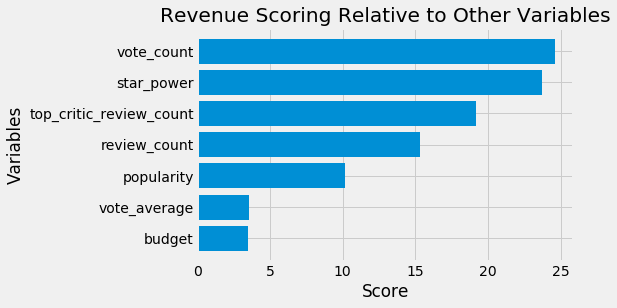

In [28]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
y_values = df_sorted['variables']
important = df_sorted['values'] * 100
# Make a bar chart
plt.barh(y_values, important, orientation = 'horizontal')
# Tick labels for x axis
plt.yticks(y_values, rotation='horizontal')
# Axis labels and title
plt.ylabel('Variables'); plt.xlabel('Score'); plt.title('Revenue Scoring Relative to Other Variables');

plt.savefig('../Output/movie_hbar.png')